<a href="https://colab.research.google.com/github/lucapoit/tech_challenge_03/blob/main/tech_challenge_03_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tech challenge 3

grupo 6MELT - 28


### 0. imports

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
import re
import os
import requests

import holidays


Esse token é para uma API gratuita e com data de validade, portanto nao há problema na exposição


In [ ]:
airports_API_token = '681f00158192b2490e163f8feba6046c5cce9e3935446a3222b3a540a826429d696c742a8fc020c5943746172a11ca03'


### 1. Carregar dados

In [ ]:
current_dir = os.getcwd()
data_dir = current_dir

In [ ]:
current_dir

'/content'

In [ ]:
airlines_df= pd.read_csv(f'{data_dir}/airlines.csv')
airports_df= pd.read_csv(f'{data_dir}/airports.csv')


In [ ]:
flights_df= pd.read_csv(f'{data_dir}/flights.csv', low_memory=False)

### 2. Exploração preliminar

##### AIRLINES

In [ ]:
airlines_df

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [ ]:
airlines_df.describe()

,IATA_CODE,AIRLINE
count,14,14
unique,14,14
top,UA,United Air Lines Inc.
freq,1,1


In [ ]:
len(airlines_df[airlines_df['AIRLINE'].isna() == True] | airlines_df[airlines_df['IATA_CODE'].isna() == True])

0

Sem valores NULL e todos únicos, essa tabela de dimensão parece bem comportada

##### AIRPORTS

In [ ]:
airports_df

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [ ]:
airports_df.describe(include='all')

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
count,322,322,322,322,322,319.000000,319.000000
unique,322,322,308,54,1,NaN,NaN
top,YUM,Yuma International Airport,Albany,TX,USA,NaN,NaN
freq,1,1,2,24,322,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,38.981244,-98.378964
std,NaN,NaN,NaN,NaN,NaN,8.616736,21.523492
min,NaN,NaN,NaN,NaN,NaN,13.483450,-176.646030
25%,NaN,NaN,NaN,NaN,NaN,33.652040,-110.839385
50%,NaN,NaN,NaN,NaN,NaN,39.297610,-93.403070
75%,NaN,NaN,NaN,NaN,NaN,43.154675,-82.722995


<Axes: >

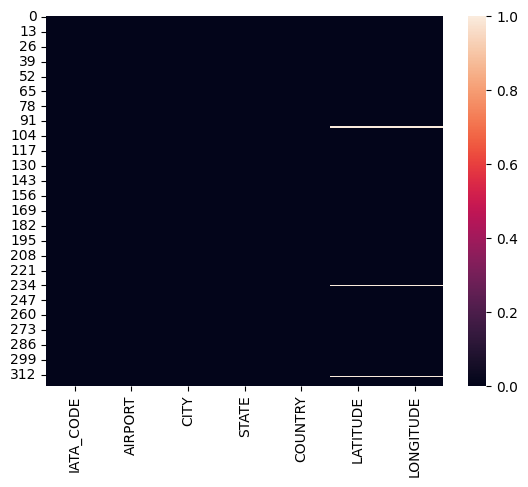

In [ ]:
sns.heatmap(airports_df.isna())

In [ ]:
airports_df.isna().sum()

,0
IATA_CODE,0
AIRPORT,0
CITY,0
STATE,0
COUNTRY,0
LATITUDE,3
LONGITUDE,3


In [ ]:
airports_df[airports_df['LATITUDE'].isna() == True]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


Para casos em que as coordenadas do aeroporto nao estão preenchidas, podemos preenche-las usando uma API

In [ ]:
def fill_airport_coord_data(airports = airports_df, api_token = airports_API_token):

    df = airports.copy()

    for idx,row in df[df['LATITUDE'].isna() == True].iterrows():

        ICAO = 'K' + row['IATA_CODE']
        response = requests.get(f'https://airportdb.io/api/v1/airport/{ICAO}?apiToken={api_token}')
        data = response.json()

        if response:

            try:
                df.loc[idx, 'LATITUDE'] = data['latitude_deg']
                df.loc[idx, 'LONGITUDE'] = data['longitude_deg']

            except ValueError as e:
                print(e)

    print(df[df['LATITUDE'].isna() == True])

    return df

In [ ]:
airports_df = fill_airport_coord_data()

    IATA_CODE                                            AIRPORT  \
313       UST  Northeast Florida Regional Airport (St. August...   

              CITY STATE COUNTRY  LATITUDE  LONGITUDE  
313  St. Augustine    FL     USA       NaN        NaN  


In [ ]:
airports_df[airports_df['LATITUDE'].isna() == True]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


Apenas um aeroporto segue sem dados, nesse caso, após verificar quanot ele é representativo na nossa tabela fato, podemos decidir se é necessário/possível removê-lo do modelo.

##### FLIGHTS

In [ ]:
flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
flights_df.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,1600598.0,1.600598e+06,1.600598e+06,1.600598e+06,1.600598e+06,1.600598e+06,1.556360e+06,1.556360e+06,1.555462e+06,1.555462e+06,...,1.600598e+06,1.554178e+06,1.551405e+06,1.600598e+06,1.600598e+06,322544.000000,322544.000000,322544.000000,322544.000000,322544.000000
mean,2015.0,2.267774e+00,1.444017e+01,3.976331e+00,2.237435e+03,1.326462e+03,1.335497e+03,1.012070e+01,1.631168e+01,1.358551e+03,...,1.502001e+03,1.487596e+03,5.990203e+00,2.312261e-03,2.842188e-02,13.531717,0.059855,18.211934,22.501811,3.083226
std,0.0,1.014706e+00,8.746109e+00,1.986570e+00,1.788960e+03,4.763127e+02,4.881367e+02,3.754029e+01,9.484205e+00,4.887557e+02,...,4.951633e+02,5.148553e+02,4.011306e+01,4.803036e-02,1.661749e-01,26.570626,1.879639,45.940547,41.717162,21.911930
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-6.800000e+01,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,1.000000e+00,7.000000e+00,2.000000e+00,7.520000e+02,9.200000e+02,9.250000e+02,-5.000000e+00,1.100000e+01,9.400000e+02,...,1.116000e+03,1.109000e+03,-1.200000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,2.000000e+00,1.300000e+01,4.000000e+00,1.711000e+03,1.320000e+03,1.330000e+03,-1.000000e+00,1.400000e+01,1.344000e+03,...,1.524000e+03,1.519000e+03,-4.000000e+00,0.000000e+00,0.000000e+00,3.000000,0.000000,2.000000,3.000000,0.000000
75%,2015.0,3.000000e+00,2.200000e+01,6.000000e+00,3.452000e+03,1.725000e+03,1.735000e+03,9.000000e+00,1.900000e+01,1.749000e+03,...,1.918000e+03,1.918000e+03,1.000000e+01,0.000000e+00,0.000000e+00,18.000000,0.000000,18.000000,28.000000,0.000000
max,2015.0,4.000000e+00,3.100000e+01,7.000000e+00,9.794000e+03,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,...,2.400000e+03,2.400000e+03,1.971000e+03,1.000000e+00,1.000000e+00,1101.000000,241.000000,1971.000000,1313.000000,1152.000000


In [ ]:
flights_df[flights_df['CANCELLED']==1].isna().sum()

,0
YEAR,0
MONTH,0
DAY,0
DAY_OF_WEEK,0
AIRLINE,0
FLIGHT_NUMBER,0
TAIL_NUMBER,8472
ORIGIN_AIRPORT,0
DESTINATION_AIRPORT,0
SCHEDULED_DEPARTURE,0


In [ ]:
flights_df[flights_df['CANCELLED']==0].isna().sum()

,0
YEAR,0
MONTH,0
DAY,0
DAY_OF_WEEK,0
AIRLINE,0
FLIGHT_NUMBER,0
TAIL_NUMBER,0
ORIGIN_AIRPORT,0
DESTINATION_AIRPORT,0
SCHEDULED_DEPARTURE,0


Algumas colunas tem uma porcentagem significativa de valores nulos, tanto para voos cancelados como para os nao cancelados

Afim de criar gráficos com caráter temporal, vamos criar uma coluna datetime usando as colunas disponíveis

In [ ]:
def int_to_time(hhmm):

    if not np.isnan(hhmm):

        time_string = str(int(hhmm))
        time_string = '0'*(4-len(time_string))+time_string

        if time_string == '2400':
            time_string = '0000'

        return time_string

    else:
        pass

In [ ]:
flights_df['DEPARTURE_TIME_FORMAT'] = flights_df['SCHEDULED_DEPARTURE'].apply(lambda x: int_to_time(x))
flights_df['DATE'] = flights_df['YEAR'].apply(str) + ' ' + flights_df['MONTH'].apply(str) + ' ' + flights_df['DAY'].apply(str)
flights_df['DATE_TIME_FORMAT'] = pd.to_datetime(flights_df['DATE'] + ' ' + flights_df['DEPARTURE_TIME_FORMAT'], format="ISO8601")

Muitas colunas dizem respeito ao voo, ou ao cancelamento em si. Logo nao fazem sentido ao tentar separar voos cancelados dos que ocorreram normalmente, uma vez que elas trazem informação sobre o vooou cancelamento que aconteceu.

Alem disso temos a coluna YEAR que é constante no dataset e tambem o tempo de voo que, quando consideramos tambem o horario do voo, trás a mesma informação do horario estimado de chegada.

In [ ]:
flights_df = flights_df.drop(columns=['YEAR','DEPARTURE_TIME','SCHEDULED_ARRIVAL', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME',
       'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'])

### 3. Exploração voltada à modelagem

In [ ]:
flights_df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,CANCELLED,DEPARTURE_TIME_FORMAT,DATE,DATE_TIME_FORMAT
0,1,1,4,AS,98,N407AS,ANC,SEA,5,205.0,1448,0,0005,2015 1 1,2015-01-01 00:05:00
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,280.0,2330,0,0010,2015 1 1,2015-01-01 00:10:00
2,1,1,4,US,840,N171US,SFO,CLT,20,286.0,2296,0,0020,2015 1 1,2015-01-01 00:20:00
3,1,1,4,AA,258,N3HYAA,LAX,MIA,20,285.0,2342,0,0020,2015 1 1,2015-01-01 00:20:00
4,1,1,4,AS,135,N527AS,SEA,ANC,25,235.0,1448,0,0025,2015 1 1,2015-01-01 00:25:00


Verificar se alguma distribuição numerica difere muito entre as classes

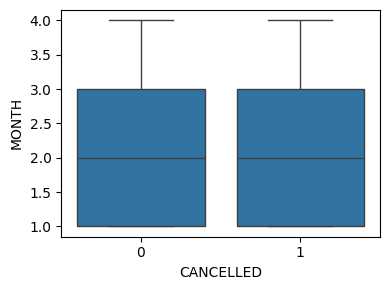

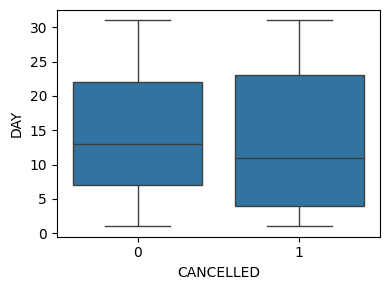

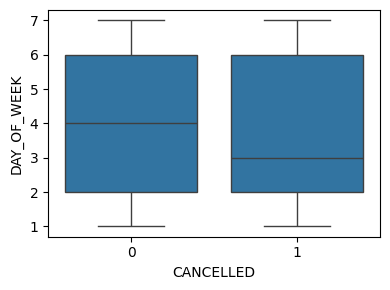

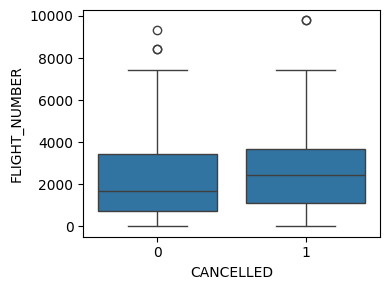

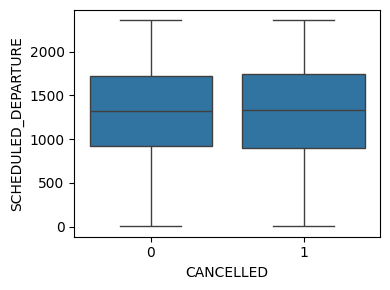

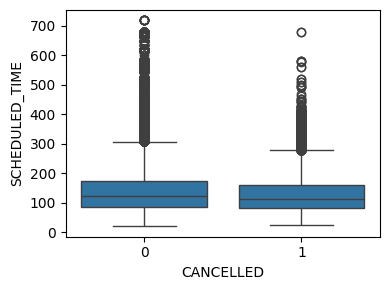

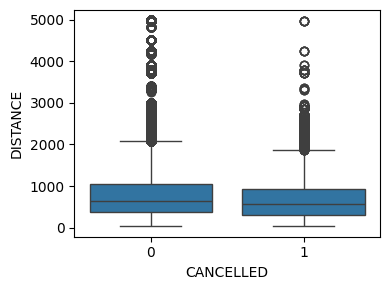

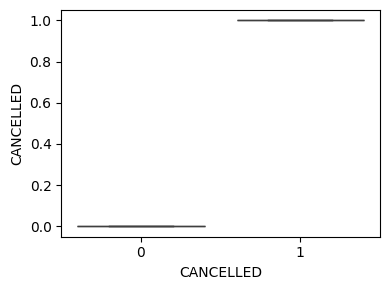

In [ ]:
for column in flights_df.columns:

    col_dtype = flights_df[column].dtype

    if np.issubdtype(col_dtype, np.number):   # numeric columns only

        plt.figure(figsize=(4, 3))           # small figure size
        sns.boxplot(data=flights_df, x='CANCELLED', y=column)
        plt.tight_layout()
        plt.show()                            # keeps each plot on screen


Para as categoricas, vejamos countplots. Fazendo com que a soma dos counts sejam igual a 100%, podemos notar picos nas distribuições dos cancelamentos, fazendo com que tenhamos ideia de features que podem induzir ao cancelamento

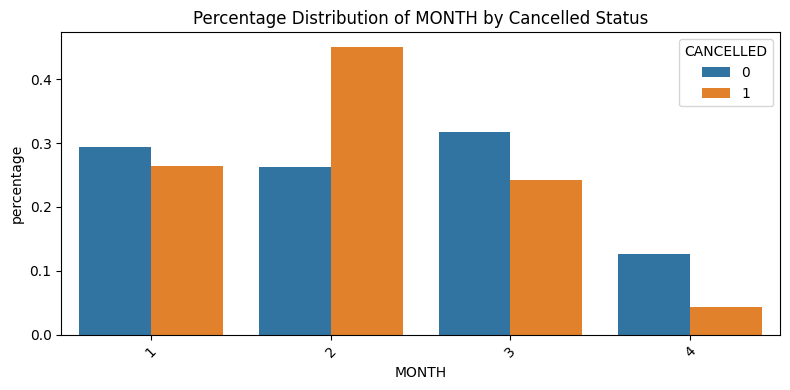

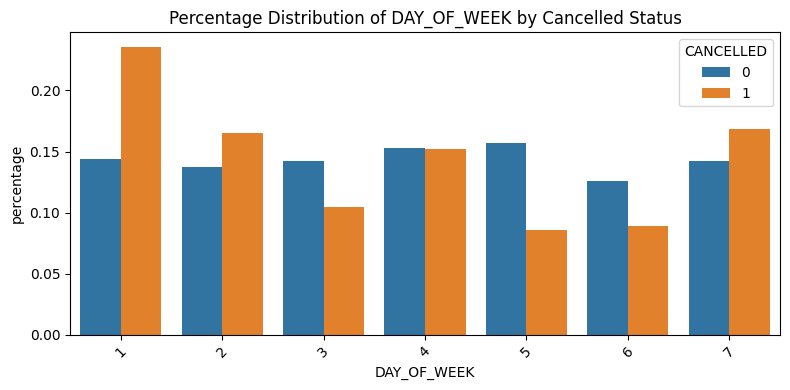

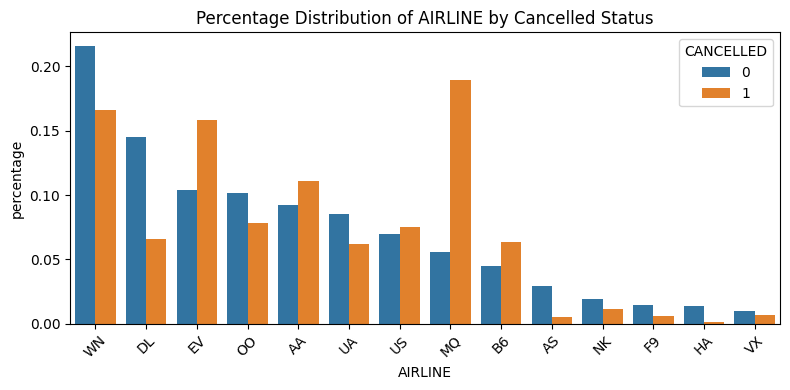

In [ ]:
categorical_cols = ['MONTH','DAY_OF_WEEK','AIRLINE']

for col in categorical_cols:
    plt.figure(figsize=(8,4))

    # compute normalized percentages
    temp = (
        flights_df.groupby('CANCELLED')[col]
          .value_counts(normalize=True)
          .rename('percentage')
          .reset_index()
    )

    sns.barplot(
        data=temp,
        x=col,
        y='percentage',
        hue='CANCELLED'
    )

    plt.title(f"Percentage Distribution of {col} by Cancelled Status")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Para visualizar algum tipo de sazonalidade

In [ ]:
count_by_date = (
    flights_df.groupby([flights_df['DATE_TIME_FORMAT'].dt.date.rename('date'), 'CANCELLED'])
      .size()
      .reset_index(name='count')
)


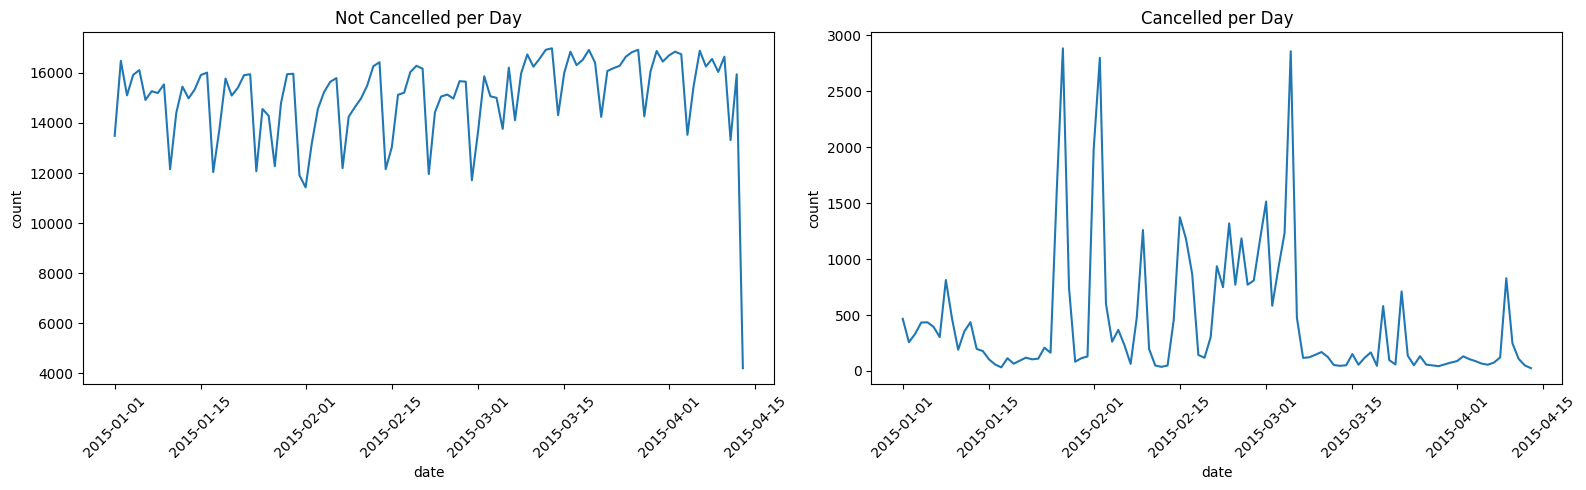

In [ ]:
not_cancelled = count_by_date[count_by_date['CANCELLED'] == 0]
cancelled = count_by_date[count_by_date['CANCELLED'] == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)

# Left: not cancelled
sns.lineplot(ax=axes[0], data=not_cancelled, x='date', y='count')
axes[0].set_title("Not Cancelled per Day")
axes[0].tick_params(axis='x', rotation=45)

# Right: cancelled
sns.lineplot(ax=axes[1], data=cancelled, x='date', y='count')
axes[1].set_title("Cancelled per Day")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Vamos adicionar uma coluna verificando se o dia em questão é um feriado, considerando que o fluxo/cancelamento pode sofrer variações devido à feriados.

In [ ]:
us_holidays = holidays.US(years=2015)

flights_df['is_holiday'] = flights_df['DATE_TIME_FORMAT'].dt.date.isin(us_holidays)

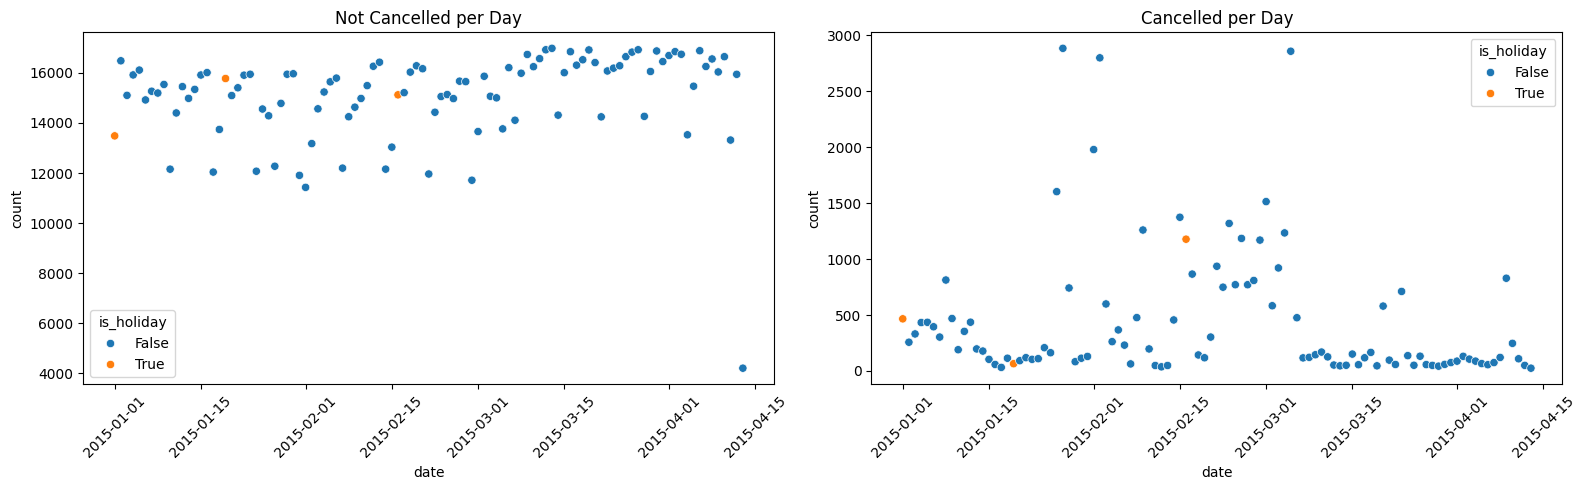

In [ ]:
count_by_date = (
    flights_df.groupby([flights_df['DATE_TIME_FORMAT'].dt.date.rename('date'), 'CANCELLED','is_holiday'])
      .size()
      .reset_index(name='count')
)

not_cancelled = count_by_date[count_by_date['CANCELLED'] == 0]
cancelled = count_by_date[count_by_date['CANCELLED'] == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)

# Left: not cancelled
sns.scatterplot(ax=axes[0], data=not_cancelled, x='date', y='count', hue='is_holiday')
axes[0].set_title("Not Cancelled per Day")
axes[0].tick_params(axis='x', rotation=45)

# Right: cancelled
sns.scatterplot(ax=axes[1], data=cancelled, x='date', y='count',hue='is_holiday')
axes[1].set_title("Cancelled per Day")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

contado por hora

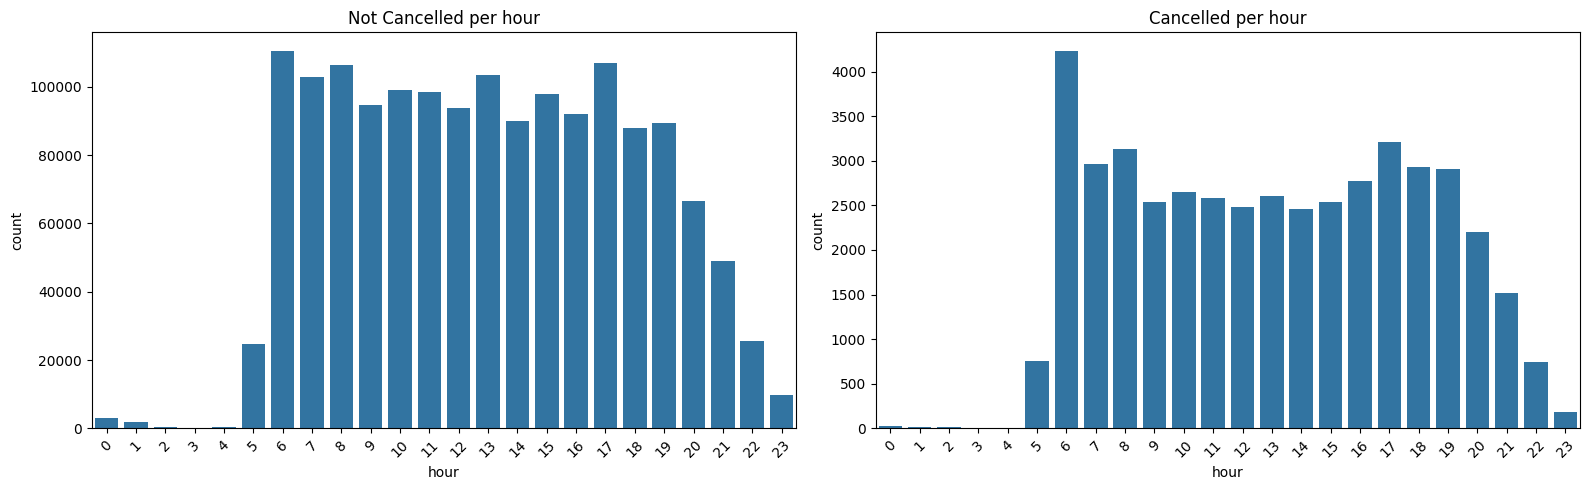

In [ ]:
count_by_hour = (
    flights_df.groupby([flights_df['DATE_TIME_FORMAT'].dt.hour.rename('hour'), 'CANCELLED'])
      .size()
      .reset_index(name='count')
)

not_cancelled_per_hour = count_by_hour[count_by_hour['CANCELLED'] == 0]
cancelled_per_hour = count_by_hour[count_by_hour['CANCELLED'] == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)

# Left: not cancelled
sns.barplot(ax=axes[0], data=not_cancelled_per_hour, x='hour', y='count')
axes[0].set_title("Not Cancelled per hour")
axes[0].tick_params(axis='x', rotation=45)

# Right: cancelled
sns.barplot(ax=axes[1], data=cancelled_per_hour, x='hour', y='count')
axes[1].set_title("Cancelled per hour")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Criamos uma coluna numerica com apenas a hora do voo

In [ ]:
flights_df['HOUR'] = flights_df['DATE_TIME_FORMAT'].dt.hour

contando por dia da semana

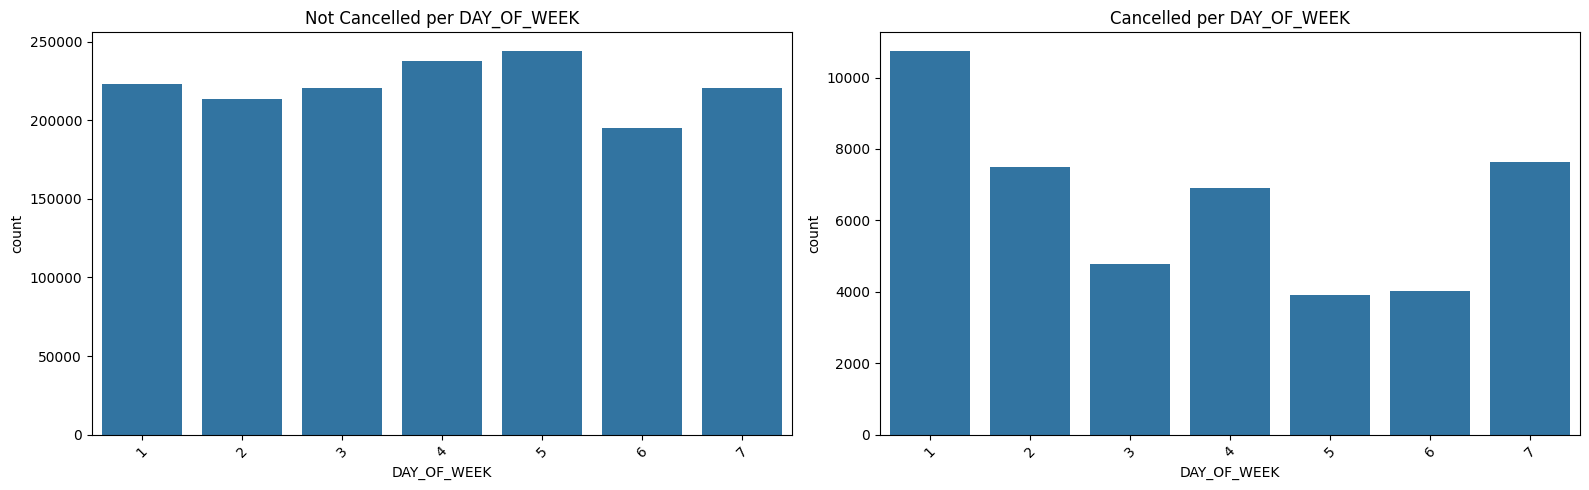

In [ ]:
count_by_day_of_week = (
    flights_df.groupby([flights_df['DAY_OF_WEEK'], 'CANCELLED'])
      .size()
      .reset_index(name='count')
)

not_cancelled_per_day_of_week = count_by_day_of_week[count_by_day_of_week['CANCELLED'] == 0]
cancelled_per_day_of_week = count_by_day_of_week[count_by_day_of_week['CANCELLED'] == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)

# Left: not cancelled
sns.barplot(ax=axes[0], data=not_cancelled_per_day_of_week, x='DAY_OF_WEEK', y='count')
axes[0].set_title("Not Cancelled per DAY_OF_WEEK")
axes[0].tick_params(axis='x', rotation=45)

# Right: cancelled
sns.barplot(ax=axes[1], data=cancelled_per_day_of_week, x='DAY_OF_WEEK', y='count')
axes[1].set_title("Cancelled per DAY_OF_WEEK")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

contando por mês

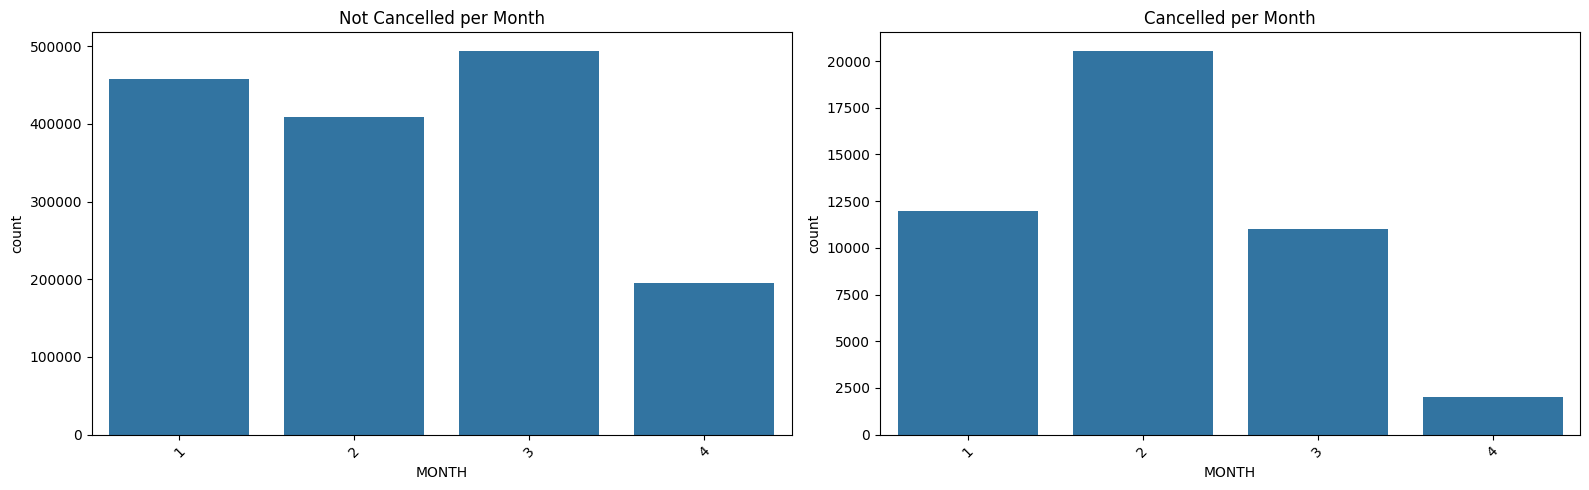

In [ ]:
count_by_month = (
    flights_df.groupby([flights_df['MONTH'], 'CANCELLED'])
      .size()
      .reset_index(name='count')
)

not_cancelled_per_month = count_by_month[count_by_month['CANCELLED'] == 0]
cancelled_per_month = count_by_month[count_by_month['CANCELLED'] == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)

# Left: not cancelled
sns.barplot(ax=axes[0], data=not_cancelled_per_month, x='MONTH', y='count')
axes[0].set_title("Not Cancelled per Month")
axes[0].tick_params(axis='x', rotation=45)

# Right: cancelled
sns.barplot(ax=axes[1], data=cancelled_per_month, x='MONTH', y='count')
axes[1].set_title("Cancelled per Month")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Quais aeronaves cancelam mais:

In [ ]:
count_by_aircraft = (
    flights_df.groupby([flights_df['TAIL_NUMBER'], 'CANCELLED'])
      .size()
      .reset_index(name='count')
)

pivoted = (
    count_by_aircraft
        .pivot(index='TAIL_NUMBER', columns='CANCELLED', values='count')
        .fillna(0)
)
pivoted.columns = ['not_cancelled', 'cancelled']   # rename for clarity

pivoted['ratio_cancelled'] = pivoted['cancelled'] / (pivoted['not_cancelled']+pivoted['cancelled'])
ratio_by_aircraft = pivoted[['ratio_cancelled']]

ratio_by_aircraft.sort_values(by='ratio_cancelled',ascending=False)

,ratio_cancelled
TAIL_NUMBER,
N866DA,1.0
N830MH,1.0
N673US,1.0
N844MQ,1.0
N844MH,0.5
...,...
N792UA,0.0
N399HA,0.0
N397AA,0.0


Não queremos perder a indormação de qual aeronave que vai voar, uma vez que existem aeronaves que proporcionalmente cancelam mais voos do que outra. Podemos usar encodings como o category_encoders.TargetEncoder ja que a cardinalidade da feature é muito alta, quase 5 mil aeronaves diferentes.

Faremos o mesmo para os aeroportos de saida e chegada bem como os números de voo, como eles também carregam informações sobre trajeto.

##### Para finalizar antes de fazer os encodings e talvez construir features, vamos remover as colunas redundantes

In [ ]:
flights_df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'CANCELLED',
       'DEPARTURE_TIME_FORMAT', 'DATE', 'DATE_TIME_FORMAT', 'is_holiday',
       'HOUR'],
      dtype='object')

In [ ]:
flights_df = flights_df.drop(columns=['DATE_TIME_FORMAT','DATE','DEPARTURE_TIME_FORMAT','SCHEDULED_DEPARTURE'])

In [ ]:
flights_df

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,CANCELLED,is_holiday,HOUR
0,1,1,4,AS,98,N407AS,ANC,SEA,205.0,1448,0,True,0
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,280.0,2330,0,True,0
2,1,1,4,US,840,N171US,SFO,CLT,286.0,2296,0,True,0
3,1,1,4,AA,258,N3HYAA,LAX,MIA,285.0,2342,0,True,0
4,1,1,4,AS,135,N527AS,SEA,ANC,235.0,1448,0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600593,4,13,1,DL,1632,N948DN,ORD,MSP,88.0,334,0,False,9
1600594,4,13,1,EV,4626,N12166,MSP,IAH,177.0,1034,0,False,9
1600595,4,13,1,HA,349,N476HA,KOA,OGG,33.0,84,0,False,9
1600596,4,13,1,UA,1055,N73291,SAT,DEN,136.0,794,0,False,9


### 4. Encoding, modelos e experimentação

#### 4.0 imports para modelagem

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import category_encoders as ce

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay,
    f1_score
)


#### 4.0.1 train/test split

In [ ]:
X = flights_df.drop(columns='CANCELLED')
y = flights_df['CANCELLED']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#### 4.0.2 encoding

In [ ]:
categorical_cols = ['AIRLINE','FLIGHT_NUMBER','TAIL_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT']

encoder = ce.TargetEncoder(cols=categorical_cols)

encoder.fit(X_train[categorical_cols], y_train)

X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded  = encoder.transform(X_test[categorical_cols])

X_train = X_train.copy()
X_test = X_test.copy()

X_train[categorical_cols] = X_train_encoded
X_test[categorical_cols] = X_test_encoded

In [ ]:
pos = sum(y_train == 1)
neg = sum(y_train == 0)

scale_pos_weight = neg / pos
print(scale_pos_weight)

34.183766554926635


O downcast diminui o uso de memória diminuindo os int e float de 64 para 32

In [ ]:
def downcast(df):
    float_cols = df.select_dtypes(include=['float'])
    int_cols = df.select_dtypes(include=['int'])

    df[float_cols.columns] = df[float_cols.columns].astype('float32')
    df[int_cols.columns] = df[int_cols.columns].astype('int32')

    return df

X_train = downcast(X_train)
X_test = downcast(X_test)

In [ ]:
# Create classification matrices
# dtrain_clf = xgb.DMatrix(X_train, y_train)
# dtest_clf = xgb.DMatrix(X_test, y_test)

#### 4.1 model_1 baseline

In [ ]:
model_1 = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    n_estimators=1000,
    early_stopping_rounds=50,
    eval_metric=["aucpr", "logloss"],
    device='gpu'
)

model_1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

[0]	validation_0-aucpr:0.26869	validation_0-logloss:0.67360
[100]	validation_0-aucpr:0.37362	validation_0-logloss:0.38390
[200]	validation_0-aucpr:0.40698	validation_0-logloss:0.34985
[300]	validation_0-aucpr:0.43425	validation_0-logloss:0.32420
[400]	validation_0-aucpr:0.44922	validation_0-logloss:0.30819
[500]	validation_0-aucpr:0.45922	validation_0-logloss:0.29459
[600]	validation_0-aucpr:0.46670	validation_0-logloss:0.28376
[700]	validation_0-aucpr:0.47435	validation_0-logloss:0.27345
[800]	validation_0-aucpr:0.47868	validation_0-logloss:0.26467
[900]	validation_0-aucpr:0.48212	validation_0-logloss:0.25667
[999]	validation_0-aucpr:0.48557	validation_0-logloss:0.24921


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='gpu', early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['aucpr', 'logloss'],
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred))

    print("\n=== Confusion Matrix ===")
    print(confusion_matrix(y_test, y_pred))

    print("\n=== Key Metrics ===")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")

    # Class-specific metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"\nTrue Positives: {tp} ({tp/y_test.sum()*100:.1f}% of cancelled flights)")
    print(f"False Negatives: {fn} ({fn/y_test.sum()*100:.1f}% of cancelled flights)")
    print(f"False Positives: {fp} ({fp/(len(y_test)-y_test.sum())*100:.1f}% of not-cancelled flights)")


In [ ]:
evaluate_model(model_1, X_test, y_test)

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [16:56:25] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.90      0.95   1145839
           1       0.11      0.80      0.20     17977

    accuracy                           0.90   1163816
   macro avg       0.55      0.85      0.57   1163816
weighted avg       0.98      0.90      0.93   1163816


=== Confusion Matrix ===
[[1031832  114007]
 [   3529   14448]]

=== Key Metrics ===
F1-Score: 0.1973
ROC-AUC: 0.9279
PR-AUC: 0.4856

True Positives: 14448 (80.4% of cancelled flights)
False Negatives: 3529 (19.6% of cancelled flights)
False Positives: 114007 (9.9% of not-cancelled flights)


O modelo parece funcional de alguma forma, uma vez que identificou a grande maioria dos voos cancelados, porem com um trade of de ter 112k falso positivos. Cenário esse que dependendo do contexto em que o model será usado, pode ser prejudicial, em casos em que o custo de erroneamente dizer que um voo sera cancelado for muito alto

#### 4.2 hyper param tunning

Para tentar melhorar os resultados obtidos alem de tambem usar um conjunto de validação, vamos tunar os hipermarâmetros do modelo usando uma busca bayesiana.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.3 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import TPESampler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np

In [ ]:
#dividindo o conjunto de treino em treino e validação
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

#Calculando o desequilibrio entre as classes para atribuir o peso correto à elas
scale_pos_weight = len(y_train_opt[y_train_opt == 0]) / len(y_train_opt[y_train_opt == 1])

def objective(trial):
    """
    Objective function for Optuna to optimize.
    Returns PR-AUC as the metric to maximize (good for imbalanced data).
    """

    #Definindo o search space dos hiperparametros
    params = {
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'eval_metric': 'aucpr',
        'device': 'gpu',
        'scale_pos_weight': scale_pos_weight,  # Keep this fixed

        # hiperparametros a serem ajustados
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 5),  # Helpful for imbalanced data
    }

    # Criando modelo
    model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)

    model.fit(
        X_train_opt, y_train_opt,
        eval_set=[(X_val_opt, y_val_opt)],
        verbose=False
    )

    # Fazendo predições
    y_pred_proba = model.predict_proba(X_val_opt)[:, 1]

    # Calcular PR-AUC
    pr_auc = average_precision_score(y_val_opt, y_pred_proba)

    # Se quisermos logar outras metricas
    roc_auc = roc_auc_score(y_val_opt, y_pred_proba)
    trial.set_user_attr('roc_auc', roc_auc)

    return pr_auc

# Criar estudo com TPE sampler (Bayesian optimization)
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    study_name='xgboost_imbalanced'
)


print("Starting Bayesian hyperparameter optimization...")
print(f"Searching for best parameters (optimizing PR-AUC)...\n")

study.optimize(
    objective,
    n_trials=20,
    show_progress_bar=True,
    n_jobs=1
)


print("\n" + "="*60)
print("OPTIMIZATION COMPLETE")
print("="*60)
print(f"\nBest PR-AUC: {study.best_value:.4f}")
print(f"Best ROC-AUC: {study.best_trial.user_attrs['roc_auc']:.4f}")
print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-12-11 16:56:51,304] A new study created in memory with name: xgboost_imbalanced


Starting Bayesian hyperparameter optimization...
Searching for best parameters (optimizing PR-AUC)...



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-11 16:57:23,946] Trial 0 finished with value: 0.45533762828969887 and parameters: {'max_depth': 6, 'learning_rate': 0.2536999076681772, 'n_estimators': 759, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598, 'max_delta_step': 4}. Best is trial 0 with value: 0.45533762828969887.
[I 2025-12-11 16:57:41,754] Trial 1 finished with value: 0.3716183216659576 and parameters: {'max_depth': 3, 'learning_rate': 0.2708160864249968, 'n_estimators': 850, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'min_child_weight': 2, 'gamma': 1.5212112147976886, 'reg_alpha': 0.00052821153945323, 'reg_lambda': 7.71800699380605e-05, 'max_delta_step': 1}. Best is trial 0 with value: 0.45533762828969887.
[I 2025-12-11 16:58:02,234] Trial 2 finished with value: 0.4125333403832435 and parameters: {'max_depth': 9, 'learning_rate': 0.016071

In [ ]:
# treinar modelo com melhores parametros
print("\n" + "="*60)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*60)

best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'eval_metric': 'aucpr',
    'device': 'gpu',
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1
})

final_model = xgb.XGBClassifier(**best_params)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_val_opt, y_val_opt)],
    verbose=100
)





TRAINING FINAL MODEL WITH BEST PARAMETERS
[0]	validation_0-aucpr:0.07765
[100]	validation_0-aucpr:0.60133
[200]	validation_0-aucpr:0.73384
[300]	validation_0-aucpr:0.82501
[400]	validation_0-aucpr:0.88320
[500]	validation_0-aucpr:0.92064
[600]	validation_0-aucpr:0.94615
[700]	validation_0-aucpr:0.96158
[800]	validation_0-aucpr:0.97259
[900]	validation_0-aucpr:0.98093
[945]	validation_0-aucpr:0.98381


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7989499894055425, device='gpu',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=0.4424625102595975, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13962563737015762,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=1, max_depth=12, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=946, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
# rodar o modelo com o test_set
print("\n" + "="*60)
print("EVALUATION ON TEST SET")
print("="*60)

y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nKey Metrics:")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"\nTrue Positives: {tp} ({tp/y_test.sum()*100:.1f}% of cancelled flights)")
print(f"False Negatives: {fn} ({fn/y_test.sum()*100:.1f}% of cancelled flights)")
print(f"False Positives: {fp} ({fp/(len(y_test)-y_test.sum())*100:.1f}% of not-cancelled flights)")

print("\n" + "="*60)
print("OPTIMIZATION VISUALIZATION")
print("="*60)

try:
    import matplotlib.pyplot as plt
    from optuna.visualization import plot_optimization_history, plot_param_importances

    # Plot optimization history
    fig1 = plot_optimization_history(study)
    fig1.show()

    # Plot parameter importances
    fig2 = plot_param_importances(study)
    fig2.show()

except ImportError:
    print("Install plotly for visualization: pip install plotly")


EVALUATION ON TEST SET

Confusion Matrix:
[[1130368   15471]
 [   7163   10814]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1145839
           1       0.41      0.60      0.49     17977

    accuracy                           0.98   1163816
   macro avg       0.70      0.79      0.74   1163816
weighted avg       0.98      0.98      0.98   1163816


Key Metrics:
F1-Score: 0.4886
ROC-AUC: 0.9318
PR-AUC: 0.5587

True Positives: 10814 (60.2% of cancelled flights)
False Negatives: 7163 (39.8% of cancelled flights)
False Positives: 15471 (1.4% of not-cancelled flights)

OPTIMIZATION VISUALIZATION


In [ ]:
import joblib
joblib.dump(final_model, 'best_xgb_model.pkl')

['best_xgb_model.pkl']

Conseguimos chegar em um modelo que identifica 60% dos casos em que o voo é de fato cancelado, enquanto identificou erroneamente apenas 1,5% como falso positivos. Parece suficiente para a nossa aplicação, então o modelo foi salvo.

### 5. Não supervisionado

Podemos experimentar com outros algoritmos de aprendizado de máquinas. Vamos agora explorar os resultados obtidos no caso em que não usamos os labels, ou seja, com um algoritmo de aprendizado não supervisionado.

#### 5.1 Kmeans

O algoritmo vai buscar datapoints com caracteristicas similares, i.e. valores de coordenadas similares no espaço multi-dimensional, atribuindo assim, valores aos clusters encontrados. Pontos próximos serão atribuídos ao mesmo cluster.

FEATURE IMPORTANCE ANALYSIS FOR CLUSTERING

1. Preparing data...
Total features: 12
Samples: 1,280,477

2. Standardizing features...

3. Analyzing feature importance via PCA...

Explained variance by first 10 components:
  PC1: 20.40%
  PC2: 14.46%
  PC3: 10.66%
  PC4: 9.50%
  PC5: 8.39%
  PC6: 7.49%
  PC7: 7.34%
  PC8: 6.33%
  PC9: 5.79%
  PC10: 5.42%
Cumulative: 95.79%

TOP 20 MOST IMPORTANT FEATURES FOR CLUSTERING
            feature  importance
     SCHEDULED_TIME    0.135501
           DISTANCE    0.134489
            AIRLINE    0.103587
      FLIGHT_NUMBER    0.092669
     ORIGIN_AIRPORT    0.091741
              MONTH    0.089411
DESTINATION_AIRPORT    0.087681
         is_holiday    0.075002
        TAIL_NUMBER    0.065084
        DAY_OF_WEEK    0.057841
                DAY    0.055943
               HOUR    0.011053


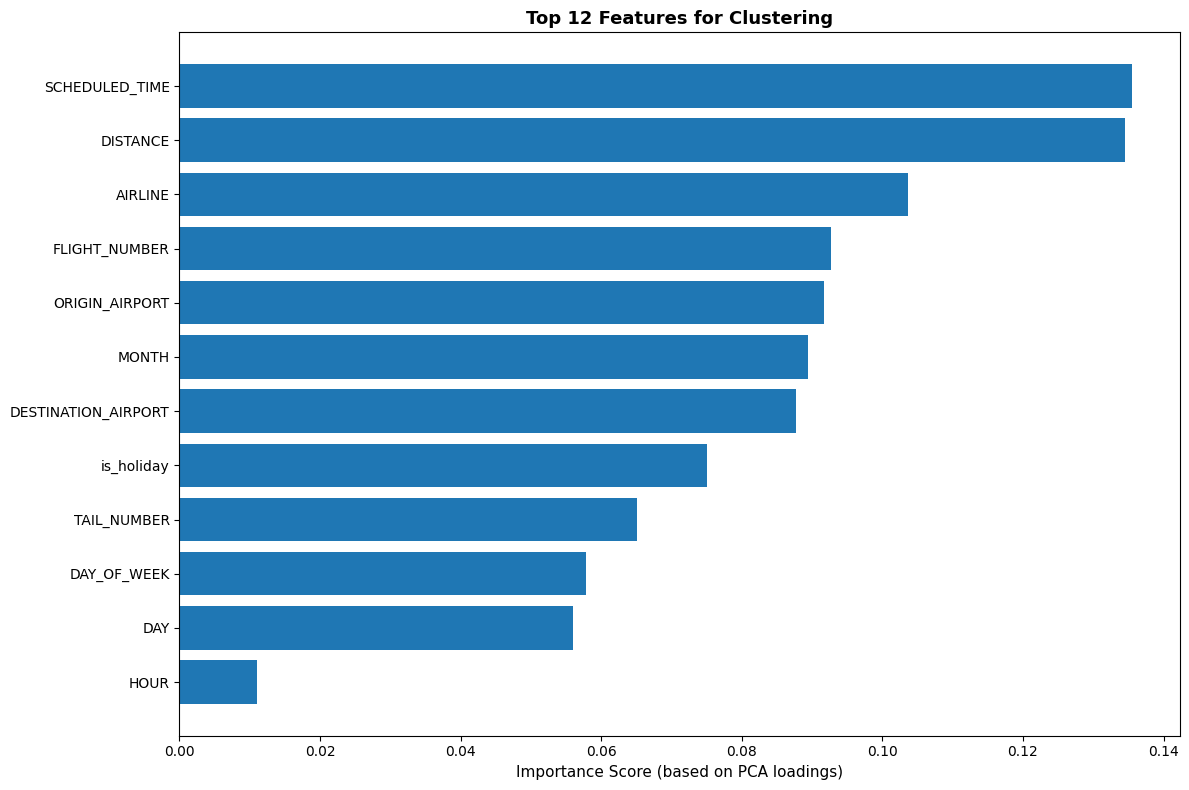


ITERATIVE CLUSTERING WITH DIFFERENT FEATURE SETS

Threshold: 100% importance | Features: 12
  Accuracy: 83.53% | Class separation: 8.8%

Threshold: 95% importance | Features: 10
  Accuracy: 83.54% | Class separation: 8.9%

Threshold: 90% importance | Features: 9
  Accuracy: 83.54% | Class separation: 8.8%

Threshold: 85% importance | Features: 8
  Accuracy: 80.86% | Class separation: 6.0%

Threshold: 80% importance | Features: 7
  Accuracy: 80.83% | Class separation: 6.0%

Threshold: 75% importance | Features: 7
  Accuracy: 80.83% | Class separation: 6.0%

RESULTS SUMMARY
 threshold  n_features  accuracy  class_separation
      1.00          12  0.835301          8.841092
      0.95          10  0.835376          8.853868
      0.90           9  0.835388          8.848209
      0.85           8  0.808601          5.977197
      0.80           7  0.808346          5.978756
      0.75           7  0.808346          5.978756

RECOMMENDATIONS

Best by clustering quality (Silhouette):

Bes

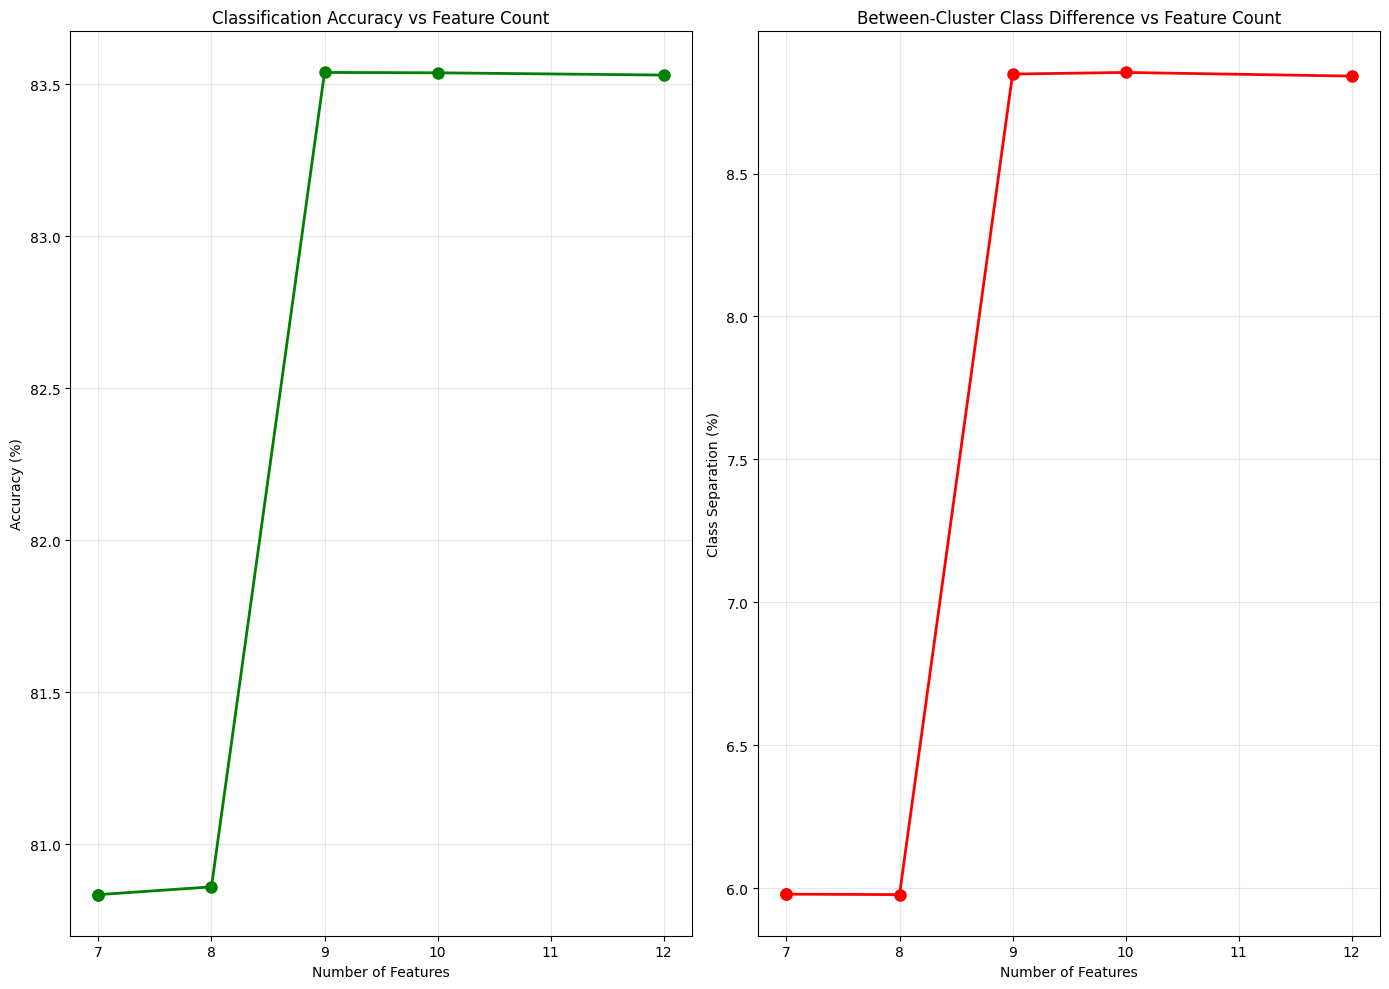


FINAL CLUSTERING WITH OPTIMAL FEATURES

Using 10 features
Selected features: ['SCHEDULED_TIME', 'DISTANCE', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'MONTH', 'DESTINATION_AIRPORT', 'is_holiday', 'TAIL_NUMBER', 'DAY_OF_WEEK'] 

Classification Report:
               precision    recall  f1-score   support

Not Cancelled       0.99      0.84      0.91   1244084
    Cancelled       0.10      0.61      0.17     36393

     accuracy                           0.84   1280477
    macro avg       0.54      0.73      0.54   1280477
 weighted avg       0.96      0.84      0.89   1280477



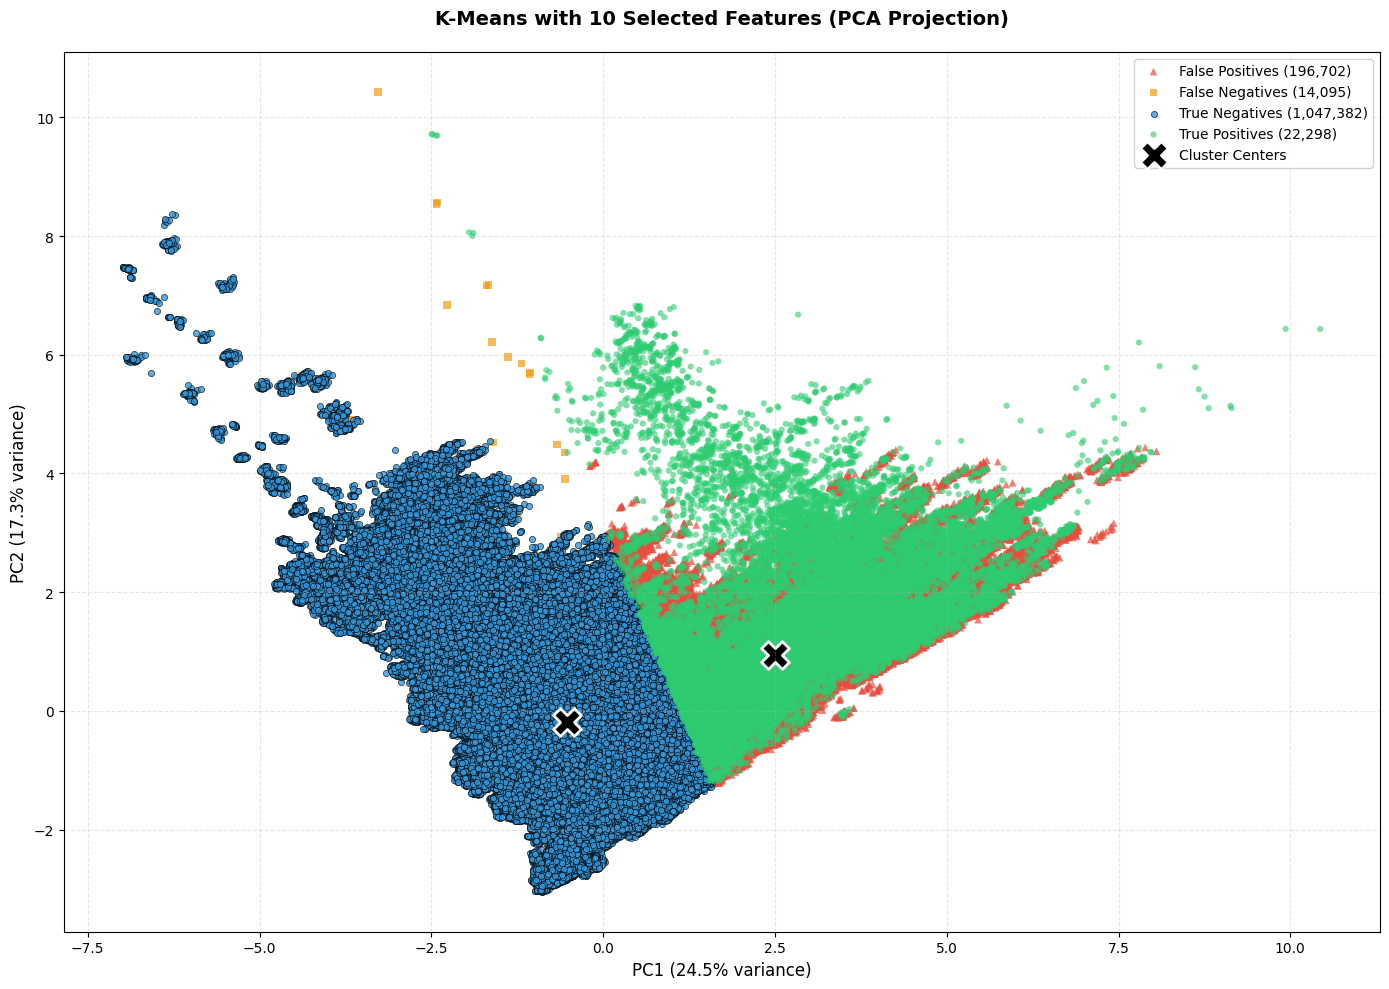


ANALYSIS COMPLETE


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    confusion_matrix,
    classification_report
)

print("="*60)
print("FEATURE IMPORTANCE ANALYSIS FOR CLUSTERING")
print("="*60)

# Data preparation
print("\n1. Preparing data...")
df_train = pd.DataFrame(X_train.copy())
df_train['target'] = y_train
df_train_clean = df_train.dropna()

y_train_clean = df_train_clean['target'].values
X_train_clean = df_train_clean.drop('target', axis=1)

# Get feature names (assuming X_train is a DataFrame, otherwise create generic names)
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns.tolist()
else:
    feature_names = [f'feature_{i}' for i in range(X_train_clean.shape[1])]

print(f"Total features: {len(feature_names)}")
print(f"Samples: {len(X_train_clean):,}")

# Standardize features (important for PCA)
print("\n2. Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_clean)

# Initial PCA to analyze feature importance
print("\n3. Analyzing feature importance via PCA...")
pca_full = PCA(n_components=min(10, len(feature_names)))
pca_full.fit(X_scaled)

print(f"\nExplained variance by first 10 components:")
for i, var in enumerate(pca_full.explained_variance_ratio_[:10]):
    print(f"  PC{i+1}: {var*100:.2f}%")
print(f"Cumulative: {np.sum(pca_full.explained_variance_ratio_)*100:.2f}%")

# Calculate feature importance based on PCA loadings
# Features with high loadings on top PCs are most important
n_top_components = 3  # Focus on first 3 PCs
feature_importance = np.abs(pca_full.components_[:n_top_components]).sum(axis=0)
feature_importance = feature_importance / feature_importance.sum()

# Create DataFrame with feature importance
feature_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES FOR CLUSTERING")
print("="*60)
print(feature_df.head(20).to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))
top_n = min(30, len(feature_names))
feature_df_top = feature_df.head(top_n)
ax.barh(range(top_n), feature_df_top['importance'].values)
ax.set_yticks(range(top_n))
ax.set_yticklabels(feature_df_top['feature'].values)
ax.set_xlabel('Importance Score (based on PCA loadings)', fontsize=11)
ax.set_title(f'Top {top_n} Features for Clustering', fontsize=13, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Iterative feature selection
print("\n" + "="*60)
print("ITERATIVE CLUSTERING WITH DIFFERENT FEATURE SETS")
print("="*60)

feature_thresholds = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75]  # Cumulative importance thresholds
results = []

for threshold in feature_thresholds:
    # Select features based on cumulative importance
    cumsum = feature_df['importance'].cumsum()
    selected_features = feature_df[cumsum <= threshold]['feature'].tolist()

    # Ensure we have at least some features
    if len(selected_features) < 5:
        selected_features = feature_df['feature'].head(5).tolist()

    # Get indices of selected features
    selected_indices = [feature_names.index(f) for f in selected_features]
    X_selected = X_scaled[:, selected_indices]

    print(f"\nThreshold: {threshold*100:.0f}% importance | Features: {len(selected_features)}")

    # Perform K-Means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_selected)

    # Calculate metrics
    # silhouette = silhouette_score(X_selected, cluster_labels)
    # davies_bouldin = davies_bouldin_score(X_selected, cluster_labels)

    # Map clusters to labels
    cluster_0_ratio = np.sum((cluster_labels == 0) & (y_train_clean == 1)) / np.sum(cluster_labels == 0)
    cluster_1_ratio = np.sum((cluster_labels == 1) & (y_train_clean == 1)) / np.sum(cluster_labels == 1)

    if cluster_0_ratio > cluster_1_ratio:
        cluster_to_label = {0: 1, 1: 0}
    else:
        cluster_to_label = {0: 0, 1: 1}

    predicted_labels = np.array([cluster_to_label[c] for c in cluster_labels])

    # Calculate accuracy
    accuracy = np.sum(predicted_labels == y_train_clean) / len(y_train_clean)

    # Calculate separation between classes
    cluster_0_cancelled_pct = np.sum((cluster_labels == 0) & (y_train_clean == 1)) / np.sum(cluster_labels == 0) * 100
    cluster_1_cancelled_pct = np.sum((cluster_labels == 1) & (y_train_clean == 1)) / np.sum(cluster_labels == 1) * 100
    class_separation = abs(cluster_0_cancelled_pct - cluster_1_cancelled_pct)

    results.append({
        'threshold': threshold,
        'n_features': len(selected_features),
        # 'silhouette': silhouette,
        # 'davies_bouldin': davies_bouldin,
        'accuracy': accuracy,
        'class_separation': class_separation,
        'selected_features': selected_features
    })

    # print(f"  Silhouette: {silhouette:.4f} | DB Index: {davies_bouldin:.4f}")
    print(f"  Accuracy: {accuracy*100:.2f}% | Class separation: {class_separation:.1f}%")

# Find best configuration
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(results_df[['threshold', 'n_features', 'accuracy', 'class_separation']].to_string(index=False))

# Recommend best configuration
# best_by_silhouette = results_df.loc[results_df['silhouette'].idxmax()]
best_by_separation = results_df.loc[results_df['class_separation'].idxmax()]

print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)
print(f"\nBest by clustering quality (Silhouette):")
# print(f"  Threshold: {best_by_silhouette['threshold']*100:.0f}% | Features: {best_by_silhouette['n_features']}")
# print(f"  Silhouette: {best_by_silhouette['silhouette']:.4f}")

print(f"\nBest by class separation:")
print(f"  Threshold: {best_by_separation['threshold']*100:.0f}% | Features: {best_by_separation['n_features']}")
print(f"  Class separation: {best_by_separation['class_separation']:.1f}%")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 10))


# Plot 3: Accuracy vs n_features
axes[0].plot(results_df['n_features'], results_df['accuracy']*100, 'o-', color='green', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Classification Accuracy vs Feature Count')
axes[0].grid(True, alpha=0.3)

# Plot 4: Class separation vs n_features
axes[1].plot(results_df['n_features'], results_df['class_separation'], 'o-', color='red', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Class Separation (%)')
axes[1].set_title('Between-Cluster Class Difference vs Feature Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final clustering with best features
print("\n" + "="*60)
print("FINAL CLUSTERING WITH OPTIMAL FEATURES")
print("="*60)

best_config = best_by_separation  # or best_by_silhouette
selected_features = best_config['selected_features']
selected_indices = [feature_names.index(f) for f in selected_features]
X_final = X_scaled[:, selected_indices]

print(f"\nUsing {len(selected_features)} features")
print("Selected features:", selected_features[:10], "..." if len(selected_features) > 10 else "")

# Final K-Means
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels_final = kmeans_final.fit_predict(X_final)

# PCA for visualization (on selected features)
pca_viz = PCA(n_components=2, random_state=42)
X_pca = pca_viz.fit_transform(X_final)

# Map clusters to labels and calculate errors
cluster_0_ratio = np.sum((cluster_labels_final == 0) & (y_train_clean == 1)) / np.sum(cluster_labels_final == 0)
cluster_1_ratio = np.sum((cluster_labels_final == 1) & (y_train_clean == 1)) / np.sum(cluster_labels_final == 1)

if cluster_0_ratio > cluster_1_ratio:
    cluster_to_label = {0: 1, 1: 0}
else:
    cluster_to_label = {0: 0, 1: 1}

predicted_labels_final = np.array([cluster_to_label[c] for c in cluster_labels_final])

true_positives = (y_train_clean == 1) & (predicted_labels_final == 1)
true_negatives = (y_train_clean == 0) & (predicted_labels_final == 0)
false_positives = (y_train_clean == 0) & (predicted_labels_final == 1)
false_negatives = (y_train_clean == 1) & (predicted_labels_final == 0)

print("\nClassification Report:")
print(classification_report(y_train_clean, predicted_labels_final, target_names=['Not Cancelled', 'Cancelled']))

# Visualization
fig, ax = plt.subplots(figsize=(14, 10))

colors = {
    'true_positive': '#2ecc71',
    'true_negative': '#3498db',
    'false_positive': '#e74c3c',
    'false_negative': '#f39c12'
}


ax.scatter(X_pca[false_positives, 0], X_pca[false_positives, 1],
           c=colors['false_positive'], alpha=0.7, s=30, marker='^',
           label=f'False Positives ({np.sum(false_positives):,})', edgecolors='none')

ax.scatter(X_pca[false_negatives, 0], X_pca[false_negatives, 1],
           c=colors['false_negative'], alpha=0.7, s=30, marker='s',
           label=f'False Negatives ({np.sum(false_negatives):,})', edgecolors='none')

ax.scatter(X_pca[true_negatives, 0], X_pca[true_negatives, 1],
           c=colors['true_negative'], alpha=0.8, s=20,
           label=f'True Negatives ({np.sum(true_negatives):,})', edgecolors='black',linewidths=0.5)

ax.scatter(X_pca[true_positives, 0], X_pca[true_positives, 1],
           c=colors['true_positive'], alpha=0.6, s=20,
           label=f'True Positives ({np.sum(true_positives):,})', edgecolors='none')

cluster_centers_pca = pca_viz.transform(kmeans_final.cluster_centers_)
ax.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
           c='black', marker='X', s=400,
           label='Cluster Centers', edgecolors='white', linewidths=2)

ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title(f'K-Means with {len(selected_features)} Selected Features (PCA Projection)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


Preparing test data...
Test set shape after cleaning: (320119, 12)
Test samples: 320,119
Class distribution:
  Class 0: 311,022 (97.16%)
  Class 1: 9,097 (2.84%)

Using 10 selected features for prediction

Test set cluster distribution:
  Cluster 0: 54,612 samples
  Cluster 1: 265,507 samples

TEST SET PERFORMANCE

Classification Report:
               precision    recall  f1-score   support

Not Cancelled       0.99      0.84      0.91    311022
    Cancelled       0.10      0.59      0.17      9097

     accuracy                           0.83    320119
    macro avg       0.54      0.72      0.54    320119
 weighted avg       0.96      0.83      0.89    320119


Confusion Matrix:
[[261800  49222]
 [  3707   5390]]

Detailed Breakdown:
True Positives: 5,390 (59.25% of cancelled)
True Negatives: 261,800 (84.17% of not cancelled)
False Positives: 49,222 (15.83% of not cancelled)
False Negatives: 3,707 (40.75% of cancelled)

TEST SET VISUALIZATION


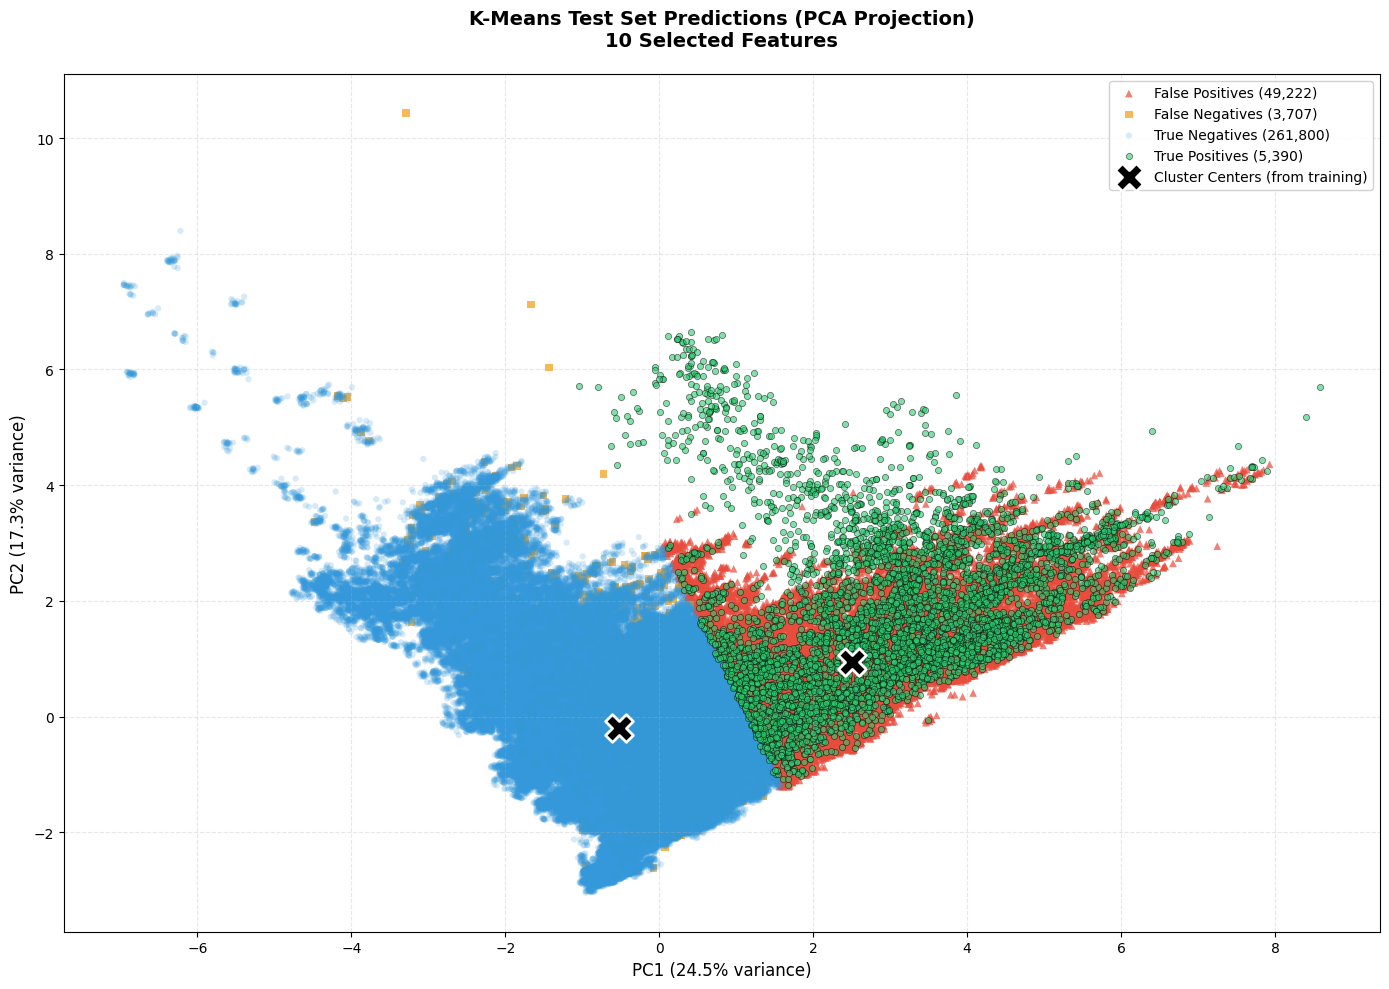


Visualization complete!

Color Legend:
  🔵 Blue circles = True Negatives (correctly predicted not cancelled)
  🟢 Green circles = True Positives (correctly predicted cancelled)
  🔺 Red triangles = False Positives (incorrectly predicted cancelled)
  🟧 Orange squares = False Negatives (incorrectly predicted not cancelled)
  ✖️  Black X = Cluster centers from training

TRAINING vs TEST COMPARISON

   Metric Training   Test Difference
 Accuracy   0.8354 0.8347    -0.0007
Precision   0.1018 0.0987    -0.0031
   Recall   0.6127 0.5925    -0.0202
 F1-Score   0.1746 0.1692    -0.0054

ANALYSIS COMPLETE


In [ ]:

# Prepare test data
print("\nPreparing test data...")
df_test = X_test.copy()
df_test['target'] = y_test
df_test_clean = df_test.dropna()

y_test_clean = df_test_clean['target'].values
X_test_clean = df_test_clean.drop('target', axis=1)

print(f"Test set shape after cleaning: {X_test_clean.shape}")
print(f"Test samples: {len(X_test_clean):,}")
print(f"Class distribution:")
print(f"  Class 0: {np.sum(y_test_clean == 0):,} ({np.sum(y_test_clean == 0)/len(y_test_clean)*100:.2f}%)")
print(f"  Class 1: {np.sum(y_test_clean == 1):,} ({np.sum(y_test_clean == 1)/len(y_test_clean)*100:.2f}%)")

# Scale test data using the same scaler
X_test_scaled = scaler.transform(X_test_clean)

# Select the same features
X_test_selected = X_test_scaled[:, selected_indices]

print(f"\nUsing {len(selected_features)} selected features for prediction")

# Predict clusters on test set
cluster_labels_test = kmeans_final.predict(X_test_selected)

print(f"\nTest set cluster distribution:")
print(f"  Cluster 0: {np.sum(cluster_labels_test == 0):,} samples")
print(f"  Cluster 1: {np.sum(cluster_labels_test == 1):,} samples")

# Map clusters to labels using the same mapping from training
predicted_labels_test = np.array([cluster_to_label[c] for c in cluster_labels_test])

# Calculate test set errors
true_positives_test = (y_test_clean == 1) & (predicted_labels_test == 1)
true_negatives_test = (y_test_clean == 0) & (predicted_labels_test == 0)
false_positives_test = (y_test_clean == 0) & (predicted_labels_test == 1)
false_negatives_test = (y_test_clean == 1) & (predicted_labels_test == 0)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_test_clean, predicted_labels_test, target_names=['Not Cancelled', 'Cancelled']))

cm_test = confusion_matrix(y_test_clean, predicted_labels_test)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

print(f"\nConfusion Matrix:")
print(cm_test)

print(f"\nDetailed Breakdown:")
print(f"True Positives: {tp_test:,} ({tp_test/np.sum(y_test_clean == 1)*100:.2f}% of cancelled)")
print(f"True Negatives: {tn_test:,} ({tn_test/np.sum(y_test_clean == 0)*100:.2f}% of not cancelled)")
print(f"False Positives: {fp_test:,} ({fp_test/np.sum(y_test_clean == 0)*100:.2f}% of not cancelled)")
print(f"False Negatives: {fn_test:,} ({fn_test/np.sum(y_test_clean == 1)*100:.2f}% of cancelled)")

# PCA transform test data for visualization
X_test_pca = pca_viz.transform(X_test_selected)

print("\n" + "="*60)
print("TEST SET VISUALIZATION")
print("="*60)

# Create test set visualization
fig, ax = plt.subplots(figsize=(14, 10))

colors = {
    'true_positive': '#2ecc71',
    'true_negative': '#3498db',
    'false_positive': '#e74c3c',
    'false_negative': '#f39c12'
}


ax.scatter(X_test_pca[false_positives_test, 0], X_test_pca[false_positives_test, 1],
           c=colors['false_positive'], alpha=0.7, s=30, marker='^',
           label=f'False Positives ({np.sum(false_positives_test):,})', edgecolors='none')

ax.scatter(X_test_pca[false_negatives_test, 0], X_test_pca[false_negatives_test, 1],
           c=colors['false_negative'], alpha=0.7, s=30, marker='s',
           label=f'False Negatives ({np.sum(false_negatives_test):,})', edgecolors='none')


ax.scatter(X_test_pca[true_negatives_test, 0], X_test_pca[true_negatives_test, 1],
           c=colors['true_negative'], alpha=0.2, s=20,
           label=f'True Negatives ({np.sum(true_negatives_test):,})', edgecolors='none')

ax.scatter(X_test_pca[true_positives_test, 0], X_test_pca[true_positives_test, 1],
           c=colors['true_positive'], alpha=0.6, s=20,
           label=f'True Positives ({np.sum(true_positives_test):,})', edgecolors='black', linewidths=0.5)

# Plot cluster centers (transformed to PCA space)
cluster_centers_pca = pca_viz.transform(kmeans_final.cluster_centers_)
ax.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
           c='black', marker='X', s=400,
           label='Cluster Centers (from training)', edgecolors='white', linewidths=2)

ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title(f'K-Means Test Set Predictions (PCA Projection)\n{len(selected_features)} Selected Features',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nVisualization complete!")
print("\nColor Legend:")
print("  🔵 Blue circles = True Negatives (correctly predicted not cancelled)")
print("  🟢 Green circles = True Positives (correctly predicted cancelled)")
print("  🔺 Red triangles = False Positives (incorrectly predicted cancelled)")
print("  🟧 Orange squares = False Negatives (incorrectly predicted not cancelled)")
print("  ✖️  Black X = Cluster centers from training")

# Compare training vs test performance
print("\n" + "="*60)
print("TRAINING vs TEST COMPARISON")
print("="*60)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

train_accuracy = accuracy_score(y_train_clean, predicted_labels_final)
test_accuracy = accuracy_score(y_test_clean, predicted_labels_test)

train_f1 = f1_score(y_train_clean, predicted_labels_final)
test_f1 = f1_score(y_test_clean, predicted_labels_test)

train_precision = precision_score(y_train_clean, predicted_labels_final)
test_precision = precision_score(y_test_clean, predicted_labels_test)

train_recall = recall_score(y_train_clean, predicted_labels_final)
test_recall = recall_score(y_test_clean, predicted_labels_test)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Training': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1],
    'Difference': [test_accuracy - train_accuracy,
                   test_precision - train_precision,
                   test_recall - train_recall,
                   test_f1 - train_f1]
})

comparison_df['Training'] = comparison_df['Training'].apply(lambda x: f'{x:.4f}')
comparison_df['Test'] = comparison_df['Test'].apply(lambda x: f'{x:.4f}')
comparison_df['Difference'] = comparison_df['Difference'].apply(lambda x: f'{x:+.4f}')

print("\n" + comparison_df.to_string(index=False))

print("\n" + "="*60)
print("ANALYSIS COMPLETE")


### 6. Conclusão e discussão

####6.1 Análise
Dentre os modelos testados aqui nesse estudo, vemos que o XGBoost apresentou os melhores resultados, pois lida muito bem com Dados Desbalanceados, como no que no caso os voos cancelados têm incidência mínima sobre o montante total. Além disso o XGBoost tem parâmetros específicos para lidar com isso (scale_pos_weight).

Sobre o Kmeans, os resultados demonstram que o k-Means é inadequado para classificar voos cancelados, apresentando uma precisão baixa. O k-Means agrupa dados por proximidade geométrica sem considerar a informação de cancelamento durante o treinamento, resultando em clusters onde ambos contêm proporções similares da classe minoritária (talvez 4% vs 2%), já que os 97% de voos não-cancelados dominam o espaço de features. O mapeamento forçado de clusters para labels é arbitrário, e embora a acurácia pareça razoável (83%), ela é pior que prever sempre "não cancelado" (baseline de 97%). Mesmo com técnicas corretas como normalização, PCA e seleção de features, o k-Means falha porque tenta resolver um problema de classificação supervisionada desbalanceada usando uma ferramenta de agrupamento não.

####6.2 Melhorias propostas
Balanceamento de dados - testar técnicas como SMOTE, ADASYN ou ajustar mais agressivamente o scale_pos_weight, além de experimentar threshold tuning na probabilidade de predição para reduzir os falsos negativos;
Ensemble de modelos - combinar XGBoost com LightGBM e CatBoost via stacking ou voting, aproveitando que cada algoritmo captura padrões diferentes nos dados desbalanceados;
Otimização focada em recall - dado que detectar cancelamentos é crítico, ajustar a função objetivo do Optuna para priorizar recall sobre precision, potencialmente usando custom metrics que penalizem mais falsos negativos; e
Análise de erros - investigar os falsos negativos e os falsos positivos para identificar padrões sistemáticos (horários específicos, rotas problemáticas, condições climáticas extremas) que possam guiar feature engineering adicional ou ajustes no preprocessing dos dados categóricos.

####6.3 Próximos passos
podemos implementar uma pipeline de tratamento de dados bem como uma arquitetura aonde o modelo treinado faça parte da pipeline, pronto para o deploy em produção.

Algumas limitações, apesar de utilizar das GPUs disponíveis no google colab, o tamanho do dataset fez com que essa dependência fosse um pouco severa, rodar uma busca de parametros sem GPU
tomaria horas.


In [10]:
!jupyter nbconvert EDA_and_model.ipynb --to html

[NbConvertApp] Converting notebook EDA_and_model.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_core/application.py", line 284, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr